### Making MD Inputs
### Joe Laforet Jr.
#### jola3134@colorado.edu

This notebook serves as a self-contained utility for a user to prepare a protein-polymer system for simulation with an MD engine. We demonstrate export to both GROMACS and OpenMM. 

For simplicity, we assume the user has already generated the fragments of the polymer chains in the previous `building_random_co-polymers.ipynb` notebook. If you did NOT do this, or want to use a different set of monomers, please adjust your code accordingly.

Information is broken up to the following schema:
## Table of Contents
- 0.0 Logging/Imports
- 1.0 Load cached monomers
- 1.1 Clean the Protein
- 1.2 Pack the Protein with Polymers
- 1.3 Solvate the Protein-Polymer System
- 1.4 Export to Interchange
- 2.0 Export to MD whatever


---
* Some elements of this notebook are adapted from [`3.3-running_openmm_simulations`](https://github.com/timbernat/polymerist_examples/blob/main/3-workflows/3.3-running_openmm_simulations.ipynb) of the polymerist_examples repositiory authored by [timbernat](https://github.com/timbernat). 

#### 0.0 Logging/Imports

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, disable_kekulized_drawing

MOL_IMG_WIDTH  : int = 300
MOL_IMG_HEIGHT : int = 200
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

disable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path

OUTPUT_DIR = Path('Building_Demos') # dummy directory for writing without tampering with example inputs
OUTPUT_DIR.mkdir(exist_ok=True)

WORKING_DIR = OUTPUT_DIR / 'Fibronectin_MD_demo'
WORKING_DIR.mkdir(exist_ok=True)

project_name : str = 'Fibronectin_MD'

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


#### 1.0 Load cached monomers

In [2]:
# Load in fragment files from cache
from polymerist.polymers.monomers import MonomerGroup

#fragments_path = assemble_path(WORKING_DIR, project_name, postfix='fragments', extension='json')

fragments_path = Path('Building_Demos/ATRP_demo/ATRP_polymer_brush_fragments.json')

monogrp = MonomerGroup.from_file(fragments_path)

##### Let's take a look at what we're working with.

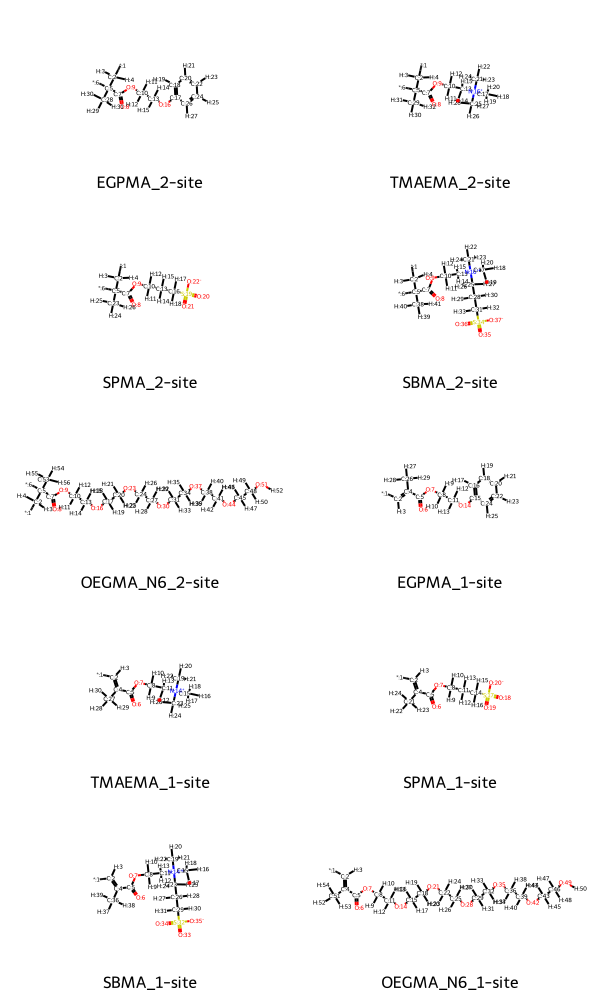

In [3]:
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

#### 1.1 Clean the Protein

In [4]:
import openff.nagl

In [5]:
from openff.toolkit import Molecule, Topology
from polymerist.mdtools.openfftools.partition import partition

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
LICENSE: No product keys!
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
/home/joelaforet/miniforge3/envs/polyzymd-env/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
############################

If we attempt to load in a PDB file, we are likely to encounter an error. OpenFF REQUIRES all protein data to be named according to the [`Chemical Component Dictionary`](https://www.wwpdb.org/data/ccd) standard. Not all PDB's are named this way, but luckily it is easy to fix this.

In [6]:
FN_path = 'Building_Demos/Fibronectin_MD_demo/1fnf_8to10_clean.pdb'

successful = False

try:
    off_pro_top = Topology.from_pdb(FN_path)
    successful = True
except ValueError:
    print("FATAL ERROR!")
    print("Contents of PDB file are not named correctly!")
    successful = False

if successful:
    was_partitioned = partition(off_pro_top)
    assert was_partitioned                         

FATAL ERROR!
Contents of PDB file are not named correctly!


In [7]:
from openmm.app import pdbfile
import pdbfixer
from pdbfixer import PDBFixer

pH = 7.0

fixer = PDBFixer(filename=FN_path)

fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()

fixer.addMissingHydrogens(pH)

pdbfile.PDBFile.writeFile(fixer.topology, 
                          fixer.positions, 
                          open('Building_Demos/Fibronectin_MD_demo/fixed_1fnf_8to10.pdb', 'w'))

off_pro_top = Topology.from_pdb('Building_Demos/Fibronectin_MD_demo/fixed_1fnf_8to10.pdb')
was_partitioned = partition(off_pro_top)
assert was_partitioned      

off_pro_top.visualize()

NGLWidget()

#### 1.2 Pack the Protein with Polymers

In [8]:
from openff.units import Quantity
from openmm.unit import nanometer, gram, centimeter
from polymerist.mdtools.openfftools import boxvectors

# Define box
box_padding: Quantity = 1.5 * nanometer  # Padding between protein and polymers
box_vecs_tight = boxvectors.get_topology_bbox(off_pro_top)
box_vecs = boxvectors.pad_box_vectors_uniform(box_vecs_tight, box_padding)

# Target density
target_density: Quantity = 1.0 * gram * centimeter**-3

##### Below is a parallel code that generates a bunch of oligomers at the same time. This would take a while if done serially.

In [9]:
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
        

In [10]:
import os
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from typing import Dict
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb
from polymerist.polymers.building import mbmol_to_rdmol
from polymerist.rdutils.rdcoords.piercing import summarize_ring_piercing
from polymerist.mdtools.openfftools.topology import topology_from_sdf
from openff.toolkit import Topology as OFFTopology
from polymerist.mdtools.openfftools import topology
from polymerist.mdtools.openfftools.partialcharge.molchargers import NAGLCharger
from polymerist.mdtools.openfftools.topology import get_largest_offmol

def make_polymer_filename(seq: str, seq_monomer_mapper: dict, charged: bool = True) -> str:
    """
    Create a self-describing filename for a polymer fragment.

    Rules:
      - Monomer names in the prefix follow alphabetical order of the mapper keys
        (e.g. 'A', 'B', 'C', ...). Only symbols that appear in `seq` are included.
      - Filename format:
            <monomer-prefix>_<sequence>_<length>-mer[_charged].sdf
        Example:
            EGPMA-TMAEMA-SPMA-SBMA-OEGMA_N6_ABCEDE_6-mer_charged.sdf

    Parameters
    ----------
    seq:
        Polymer sequence string, e.g. "ABCEDE".
    seq_monomer_mapper:
        dict mapping single-char symbols to monomer names, e.g.
        {'D': 'SBMA', 'C': 'SPMA', 'E': 'OEGMA_N6', 'A': 'EGPMA', 'B': 'TMAEMA'}
    charged:
        If True, append "_charged" before the extension.

    Returns
    -------
    filename : str
        The generated filename.
    """
    seq = str(seq)  # ensure it's a string
    if not seq:
        raise ValueError("seq must be a non-empty string")

    # Validate all symbols in seq are present in the mapper
    missing = sorted({s for s in seq} - set(seq_monomer_mapper.keys()))
    if missing:
        raise KeyError(f"Sequence contains symbols not found in mapper: {missing}")

    # Determine ordered keys = alphabetical order of mapper keys,
    # then keep only those that appear in seq (preserves the A,B,C... order)
    ordered_keys = [k for k in sorted(seq_monomer_mapper.keys()) if k in seq]

    # Map to monomer names (deduplicated by symbol presence)
    monomers_used = [seq_monomer_mapper[k] for k in ordered_keys]

    # Join monomer names with hyphens
    monomer_prefix = "-".join(monomers_used) if monomers_used else "NO_MONOMERS"

    length = len(seq)
    filename = f"{monomer_prefix}_seq={seq}_{length}-mer"
    if charged:
        filename += "_charged"
    #filename += ".sdf"
    return filename


# === wrapper around original, serial process_sequence ===
def process_sequence(args):
    """
     Needs:
    (sequence, seq_monomer_mapper, term_orient_mapper, 
     resname_map, n_monomers, monogrp, WORKING_DIR)
    """
    sequence_whole, seq_monomer_mapper, term_orient_mapper, resname_map, n_monomers, monogrp, WORKING_DIR = args

    charged_polymer_name = make_polymer_filename(sequence_whole, seq_monomer_mapper, charged=True)
    uncharged_polymer_name = make_polymer_filename(sequence_whole, seq_monomer_mapper, charged=False)

    sdf_path = assemble_path(WORKING_DIR, uncharged_polymer_name, extension='sdf')
    sdf_path_charged = assemble_path(WORKING_DIR, charged_polymer_name, extension='sdf')
    pdb_path = assemble_path(WORKING_DIR, uncharged_polymer_name, extension='pdb')

    if os.path.exists(sdf_path_charged):
        return f"Skipped {sequence_whole} (already exists)"

    offtop = None
    
    try:
        print()
        print(f"Building {sequence_whole}")
        print()

        chain = None
        offtop = None
        
        # Step 1 & 2: Build Chain and Save PDB (only if PDB doesn't exist)
        if not os.path.exists(pdb_path):
            print(f"Creating PDB for {uncharged_polymer_name}")
            head_undiff, *sequence_middle, tail_undiff = sequence_whole # split into parts
            sequence_middle : str = ''.join(sequence_middle) # unpacking mid makes it a list at first

            monogrp_local = MonomerGroup(monomers=monogrp.monomers) # make copy to avoid cross-pollination
            monogrp_local.term_orient = {
                        'head' : term_orient_mapper[head_undiff],
                        'tail' : term_orient_mapper[tail_undiff],
                        }

            # 1. Build Chain, make sure no "ring piercing events happen"

            successful_build = False
            while not successful_build:
                chain = build_linear_polymer(
                        monomers=monogrp_local,
                        n_monomers=len(sequence_whole),
                        sequence=sequence_middle, # this will be better labelled
                        energy_minimize=True,
                        allow_partial_sequences=True, # doesn't matter here but, allow you to have numbers of middle monomers that aren't multiples of 3, in this case
                        )

                poly_mol = mbmol_to_rdmol(chain)
                pinprics_out = summarize_ring_piercing(poly_mol)

                if pinprics_out == {}:
                    successful_build = True
                    print("Build Success!")
                else:
                    print("PIERCING REDO")
                    print(pinprics_out)

            # 2. Save PDB
            mbmol_to_openmm_pdb(
                pdb_path,
                chain, 
                resname_map=resname_map)
            print(f"Created PDB: {pdb_path}")
        else:
            print(f"PDB already exists: {pdb_path}")

        # Steps 3, 4, 5: Create topology and save uncharged SDF (only if SDF doesn't exist)
        if not os.path.exists(sdf_path):
            print(f"Creating topology and uncharged SDF for {uncharged_polymer_name}")
            # Need to get monogrp again for topology creation
            head_undiff, *sequence_middle, tail_undiff = sequence_whole
            monogrp_local = MonomerGroup(monomers=monogrp.monomers)
            monogrp_local.term_orient = {
                        'head' : term_orient_mapper[head_undiff],
                        'tail' : term_orient_mapper[tail_undiff],
                        }
            
            # 3. OpenFF Topology & Partition
            offtop = OFFTopology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
            was_partitioned = partition(offtop)
            assert was_partitioned

            # 4. Fix residue names
            for mol in offtop.molecules:
                for atom in mol.atoms:
                    if 'residue_name' in atom.metadata:
                        atom.metadata['extended_name'] = atom.metadata['residue_name']
                        atom.metadata['residue_name'] = atom.metadata['residue_name'][:3]

            # 5. Save standard SDF
            topology.topology_to_sdf(sdf_path, offtop)
            print(f"Created uncharged SDF: {sdf_path}")
        else:
            print(f"Uncharged SDF already exists: {sdf_path}")

        # Steps 6 & 7: Charge molecule and save charged SDF (always do this if we got here)
        print(f"Creating charged SDF for {uncharged_polymer_name}")
        
        # If we didn't create the topology above, we need to create it now for charging
        if offtop is None:
            # Need to get monogrp again for topology creation
            head_undiff, *sequence_middle, tail_undiff = sequence_whole
            monogrp_local = MonomerGroup(monomers=monogrp.monomers)
            monogrp_local.term_orient = {
                        'head' : term_orient_mapper[head_undiff],
                        'tail' : term_orient_mapper[tail_undiff],
                        }
            
            offtop = OFFTopology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
            was_partitioned = partition(offtop)
            assert was_partitioned

            # Fix residue names (in case we skipped the SDF creation step)
            for mol in offtop.molecules:
                for atom in mol.atoms:
                    if 'residue_name' in atom.metadata:
                        atom.metadata['extended_name'] = atom.metadata['residue_name']
                        atom.metadata['residue_name'] = atom.metadata['residue_name'][:3]

        # 6. Assign Partial Charges
        offmol = topology.get_largest_offmol(offtop)
        charger = NAGLCharger()
        charged_mol = charger.charge_molecule(offmol)
        charged_top = charged_mol.to_topology()

        # 7. Save charged SDF
        topology.topology_to_sdf(sdf_path_charged, charged_top)
        print(f"Wrote charged structure to {sdf_path_charged}")
        
        return f"Successfully processed {uncharged_polymer_name}"

    except Exception as e:
        error_msg = f"Warning: Failed to process {uncharged_polymer_name}: {e}"
        print(error_msg)
        return error_msg


    return f"Successfully built {sequence_whole}"


# === main loader function ===
def load_or_generate_polymers(
    sequence_counts: Dict[str, int],
    seq_monomer_mapper: dict,
    term_orient_mapper: dict,
    resname_map: dict,
    molecule_directory: str,
    monogrp,
    charged: bool = True,
) -> Dict[str, "openff.toolkit.topology.Molecule"]:
    """
    Load polymers from cache, and generate them in parallel if missing.

    Parameters
    ----------
    sequence_counts : dict
        Dict of {sequence: count} for unique sequences to load.
    seq_monomer_mapper : dict
        Mapping from sequence symbols to monomer names.
    term_orient_mapper : dict
        Mapping from sequence symbols to terminal monomer names.
    resname_map: dict
        Mapping from monomer name to 3-character code for PDB
    molecule_directory : str
        Path to cache directory for molecules.
    monogrp : MonomerGroup
        MonomerGroup object used for building.
    charged : bool
        Whether to build/load charged SDFs.

    Returns
    -------
    loaded_mols : dict
        Mapping {sequence: off_mol_object}.
    """

    missing_sequences = []
    loaded_mols = {}

    molecule_directory.mkdir(exist_ok=True)

    # Try to load from cache
    for sequence in sequence_counts:
        filename = make_polymer_filename(sequence, seq_monomer_mapper, charged=True)
        filepath = os.path.join(molecule_directory, filename)
        if not os.path.exists(filepath):
            missing_sequences.append(sequence)
            continue

        off_poly_top = topology_from_sdf(filepath)
        off_poly_mol = get_largest_offmol(off_poly_top)
        loaded_mols[sequence] = off_poly_mol

    # Build missing in parallel
    if missing_sequences:
        args_list = [
            (seq, seq_monomer_mapper, term_orient_mapper, resname_map, len(seq), monogrp, molecule_directory)
            for seq in missing_sequences
        ]

        num_cores = max(1, mp.cpu_count() // 2)
        print(f"Generating {len(missing_sequences)} polymers using {num_cores} cores...")

        with Pool(processes=num_cores) as pool:
            results = list(tqdm(
                pool.imap(process_sequence, args_list),
                total=len(args_list),
                desc="Building missing polymers"
            ))

        # Make sure all workers are done
        pool.close()
        pool.join()
        
        for msg in results:
            print(msg)

        # Reload the missing ones
        for seq in missing_sequences:
            filename = make_polymer_filename(seq, seq_monomer_mapper, charged=True) + ".sdf"
            filepath = os.path.join(molecule_directory, filename)
            off_poly_top = topology_from_sdf(filepath)
            off_poly_mol = get_largest_offmol(off_poly_top)
            loaded_mols[seq] = off_poly_mol

    return loaded_mols


[14:51:49] WARNING: not removing hydrogen atom with dummy atom neighbors


In [11]:
# draw probabilities according to experiment
# 3:3:2 + 5% SBMA, SPMA, OEGMA, EGPMA, TMAEMA

import numpy as np
from collections import Counter

probas = [0.3583, 0.3583, 0.2334, 0.05,  0.0]
chars  = [   'D',    'C',    'E',  'A',  'B']


# These come from the order in which fragments were added
# to the MonomerGroup we generated in the previous tutorial
seq_monomer_mapper = {
    'D': 'SBMA',
    'C': 'SPMA',
    'E': 'OEGMA',
    'A': 'EGPMA',
    'B': 'TMAEMA'
}

term_orient_mapper = {
    'D' : 'SBMA_1-site',
    'C' : 'SPMA_1-site',
    'E' : 'OEGMA_N6_1-site',
    'A' : 'EGPMA_1-site',
    'B' : 'TMAEMA_1-site'
}

# rename to 3-letter residue names in PDB file
resname_map={ 
    'SBMA_1-site'     : 'SB1',
    'SBMA_2-site'     : 'SB2',
    'SPMA_1-site'     : 'SP1',
    'SPMA_2-site'     : 'SP2',
    'OEGMA_N6_1-site' : 'OE1',
    'OEGMA_N6_2-site' : 'OE2',
    'EGPMA_1-site'    : 'EG1',
    'EGPMA_2-site'    : 'EG2',
    'TMAEMA_1-site'   : 'TM1',
    'TMAEMA_2-site'   : 'TM2'
}

# Step 1: Randomly generate N polymer sequences
def generate_random_polymer(N, characters, probabilities):
    return ''.join(np.random.choice(characters, size=N, p=probabilities))

polymer_sequences = [generate_random_polymer(10, chars, probas) for _ in range(63)]

# Define a canonical form: min of the string and its reverse
def canonical(s):
    return min(s, s[::-1])

# Convert all strings to their canonical form
canonical_polys = [canonical(p) for p in polymer_sequences]

# Step 2: Count how many times each unique polymer was generated
sequence_counts = Counter(canonical_polys)
print(sequence_counts)

Counter({'CDDCDACEDC': 1, 'ECCDDEEECE': 1, 'CEDECEDCCD': 1, 'DCDDDEDAED': 1, 'ADDDCCCCAE': 1, 'CCACCCECEE': 1, 'DCDCCCEDDE': 1, 'DDCCEEDCDE': 1, 'CDDEEDDCCD': 1, 'CCDDDCDCDD': 1, 'DDDCDDDECE': 1, 'DDDDEDCCED': 1, 'AACCCADDDC': 1, 'DDCDCCDCDE': 1, 'CCCEDEDEDD': 1, 'DCCDCDEDEE': 1, 'DCCCCCCCEE': 1, 'ECEDDEECDE': 1, 'CDDDEEDDEC': 1, 'CDCCDCDEEE': 1, 'CCAADEAEEC': 1, 'CEECACECED': 1, 'ADCCECDCDD': 1, 'CDCACDECEE': 1, 'CEEECDDCDE': 1, 'CCACDEEDDC': 1, 'DCCCEEDDCE': 1, 'CDDCCDECCE': 1, 'CDCCDEECDD': 1, 'ECCCCDCECE': 1, 'DDEEDCECED': 1, 'DCCCEAEDDD': 1, 'CDDEDCADCD': 1, 'CECEDEDCDE': 1, 'ACCEDDDDDD': 1, 'CCDCDCCECC': 1, 'CCCCAEDEED': 1, 'CDDCDCECDE': 1, 'CDCDEDDAEE': 1, 'CDCCECECCD': 1, 'CDDEDDDEDD': 1, 'CDDDCEDDDE': 1, 'CCAEDDCCDE': 1, 'CCDDCCCDAD': 1, 'CACCCCCDCE': 1, 'CCDECECCDC': 1, 'CCDDDCDCCD': 1, 'CECCEDDEDE': 1, 'CCDDDCDDED': 1, 'CDCCEDADCD': 1, 'CCDDCDCCDD': 1, 'CCDDDEDEDC': 1, 'DCECDDEEDE': 1, 'CCEEDCEDCE': 1, 'CEDECCCCCE': 1, 'ACCECECDEE': 1, 'CAEEDACDDC': 1, 'CECCEEDCAD': 1, 'CCAC

##### Main function that does the "polymer ensemble sampling" and structure generation

In [12]:
from typing import List, Union, Optional
from openff.interchange.components import _packmol as packmol

def pack_topology_with_random_polymers_from_sequences(offtop,
                                                       characters: List[str],
                                                       probabilities: List[float],
                                                       box_vecs,
                                                       N: int,
                                                       monogrp: MonomerGroup,
                                                       seq_monomer_mapper: dict,
                                                       term_orient_mapper: dict,
                                                       resname_map: dict,
                                                       molecule_directory: str = WORKING_DIR/'Cached_Molecules',
                                                       exclusion: Optional = None,
                                                       working_directory=None,
                                                       retain_working_files=True,
                                                       polymer_length: int = 5,
):
    '''
    Pack a Topology with N randomly generated polymer sequences, selecting matching .sdf files.

    Parameters:
    - offtop: Topology to solvate.
    - characters: Possible monomer units ("A", "B", etc).
    - probabilities: Probabilities associated with each monomer unit.
    - box_vecs: Desired box vectors.
    - N: Total number of polymer chains to insert.
    - molecule_directory: Directory where .sdf files are stored.
    - monogrp : MonomerGroup
        MonomerGroup object used for building.
    - seq_monomer_mapper : dict
        Mapping from sequence symbols to monomer names.
    - term_orient_mapper : dict
        Mapping from sequence symbols to terminal monomer names.
    - resname_map: dict
        Mapping from monomer name to 3-character code for PDB
    - polymer_length: Number of monomers per chain (default 5).
    '''
    

    assert abs(sum(probabilities) - 1.0) < 1e-8, "Probabilities must sum to 1."
    assert len(characters) == len(probabilities), "Characters and probabilities must match."

    box_vecs = boxvectors.box_vectors_flexible(box_vecs)
    min_box_vecs = boxvectors.get_topology_bbox(offtop) * 1.1
    if exclusion is not None:
        min_box_vecs = boxvectors.pad_box_vectors_uniform(min_box_vecs, exclusion)

    if not np.all(box_vecs >= min_box_vecs):
        raise boxvectors.BoxVectorError(f'Desired box dimensions ({box_vecs}) are smaller than minimum excluded Topology dimensions ({min_box_vecs})')

    box_vol = boxvectors.get_box_volume(box_vecs, units_as_openm=True)

    # Step 1: Randomly generate N polymer sequences
    def generate_random_polymer(N, characters, probabilities):
        return ''.join(np.random.choice(characters, size=N, p=probabilities))

    polymer_sequences = [generate_random_polymer(polymer_length, characters, probabilities) for _ in range(N)]

    # Define a canonical form: min of the string and its reverse
    def canonical(s):
        return min(s, s[::-1])

    # Convert all strings to their canonical form
    canonical_polys = [canonical(p) for p in polymer_sequences]

    # Step 2: Count how many times each unique polymer was generated
    sequence_counts = Counter(canonical_polys)
    print(sequence_counts)

    # Step 3: Load molecule objects matching each unique sequence
    loaded_mols = load_or_generate_polymers(sequence_counts, seq_monomer_mapper, term_orient_mapper,
                                        resname_map, molecule_directory,
                                        monogrp)
    
    # Step 4: Prepare lists for packmol
    solvent_list = []
    num_list = []
    seq_list = []

    for sequence, count in sequence_counts.items():
        print(loaded_mols[sequence])
        print(loaded_mols[sequence].partial_charges)
        solvent_list.append(loaded_mols[sequence])
        num_list.append(count)
        seq_list.append(sequence)

    # Step 5: Pack the box
    LOGGER.info(f"Packing {sum(num_list)} total polymers: {sequence_counts}")
    packed_top = packmol.pack_box(
        solvent_list,
        num_list,
        offtop,
        box_vectors=box_vecs,
        box_shape=packmol.UNIT_CUBE,
        center_solute='BRICK',
        working_directory=working_directory,
        retain_working_files=retain_working_files
    )
    LOGGER.info('Packmol packing converged')

    packed_top.box_vectors = box_vecs
    print("Sequences generated:")
    print(seq_list)
    return packed_top, solvent_list

In [13]:
import openff.nagl

In [14]:
print("Adding oligomers to box!")
LOGGER = logging.getLogger(__name__)
logging.disable(logging.ERROR)

num_oligomers = 5
polymer_length = 10

poly_pro_top, polymer_mol_list = pack_topology_with_random_polymers_from_sequences(
    offtop=off_pro_top,
    characters=chars,
    probabilities=probas,
    box_vecs=box_vecs,
    N=num_oligomers,
    monogrp=monogrp,
    seq_monomer_mapper=seq_monomer_mapper,
    term_orient_mapper=term_orient_mapper,
    resname_map=resname_map,
    polymer_length=polymer_length,
    working_directory=str(WORKING_DIR),
    retain_working_files=True
)

print("Finished adding oligomers!")

Adding oligomers to box!
Counter({'DCEDDCCDED': 1, 'ADDDEDDEAE': 1, 'CDDDDCAEED': 1, 'CCCECCECDE': 1, 'ACCCDEACAD': 1})
Generating 5 polymers using 8 cores...


Building missing polymers:   0%|          | 0/5 [00:00<?, ?it/s]






Building ADDDEDDEAEBuilding DCEDDCCDEDBuilding CDDDDCAEEDBuilding CCCECCECDEBuilding ACCCDEACAD









Creating PDB for EGPMA-SBMA-OEGMA_seq=ADDDEDDEAE_10-merCreating PDB for EGPMA-SPMA-SBMA-OEGMA_seq=ACCCDEACAD_10-merCreating PDB for SPMA-SBMA-OEGMA_seq=DCEDDCCDED_10-merCreating PDB for SPMA-SBMA-OEGMA_seq=CCCECCECDE_10-merCreating PDB for EGPMA-SPMA-SBMA-OEGMA_seq=CDDDDCAEED_10-mer






/home/joelaforet/miniforge3/envs/polyzymd-env/lib/python3.11/site-packages/mbuild/compound.py:2684: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  warn(
/home/joelaforet/miniforge3/envs/polyzymd-env/lib/python3.11/site-packages/mbuild/compound.py:2684: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  warn(
/home/joelaforet/miniforge3/envs/polyzymd-env/lib/python3.11/site-packages/mbuild/compound.py:2684: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  warn(
/home/joelaforet/miniforge3/envs/polyzymd-env/lib/python3.11/site-packages/mbuild/compound.py:2684: UserWarning: Performing energy mi

Build Success!
Created PDB: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SPMA-SBMA-OEGMA_seq=CDDDDCAEED_10-mer.pdb
Creating topology and uncharged SDF for EGPMA-SPMA-SBMA-OEGMA_seq=CDDDDCAEED_10-mer
Created uncharged SDF: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SPMA-SBMA-OEGMA_seq=CDDDDCAEED_10-mer.sdf
Creating charged SDF for EGPMA-SPMA-SBMA-OEGMA_seq=CDDDDCAEED_10-mer
Build Success!
Created PDB: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/SPMA-SBMA-OEGMA_seq=DCEDDCCDED_10-mer.pdb
Creating topology and uncharged SDF for SPMA-SBMA-OEGMA_seq=DCEDDCCDED_10-mer


[14:51:57] WARNING: Proton(s) added/removed



Created uncharged SDF: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/SPMA-SBMA-OEGMA_seq=DCEDDCCDED_10-mer.sdf
Creating charged SDF for SPMA-SBMA-OEGMA_seq=DCEDDCCDED_10-mer
Wrote charged structure to Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SPMA-SBMA-OEGMA_seq=CDDDDCAEED_10-mer_charged.sdf
Wrote charged structure to Building_Demos/Fibronectin_MD_demo/Cached_Molecules/SPMA-SBMA-OEGMA_seq=DCEDDCCDED_10-mer_charged.sdf


Building missing polymers:  20%|██        | 1/5 [00:08<00:34,  8.64s/it]

Build Success!
Created PDB: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/SPMA-SBMA-OEGMA_seq=CCCECCECDE_10-mer.pdb
Creating topology and uncharged SDF for SPMA-SBMA-OEGMA_seq=CCCECCECDE_10-mer
Created uncharged SDF: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/SPMA-SBMA-OEGMA_seq=CCCECCECDE_10-mer.sdf
Creating charged SDF for SPMA-SBMA-OEGMA_seq=CCCECCECDE_10-mer
Build Success!
Created PDB: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SPMA-SBMA-OEGMA_seq=ACCCDEACAD_10-mer.pdb
Creating topology and uncharged SDF for EGPMA-SPMA-SBMA-OEGMA_seq=ACCCDEACAD_10-mer
Build Success!
Created PDB: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SBMA-OEGMA_seq=ADDDEDDEAE_10-mer.pdb
Creating topology and uncharged SDF for EGPMA-SBMA-OEGMA_seq=ADDDEDDEAE_10-mer
Created uncharged SDF: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SPMA-SBMA-OEGMA_seq=ACCCDEACAD_10-mer.sdf
Creating charged SDF for EGPMA-SPMA-SBMA-OEGMA_seq=ACCCDEACAD_10-mer


[14:52:00] WARNING: Proton(s) added/removed



Wrote charged structure to Building_Demos/Fibronectin_MD_demo/Cached_Molecules/SPMA-SBMA-OEGMA_seq=CCCECCECDE_10-mer_charged.sdf
Created uncharged SDF: Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SBMA-OEGMA_seq=ADDDEDDEAE_10-mer.sdf
Creating charged SDF for EGPMA-SBMA-OEGMA_seq=ADDDEDDEAE_10-mer
Wrote charged structure to Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SPMA-SBMA-OEGMA_seq=ACCCDEACAD_10-mer_charged.sdf
Wrote charged structure to Building_Demos/Fibronectin_MD_demo/Cached_Molecules/EGPMA-SBMA-OEGMA_seq=ADDDEDDEAE_10-mer_charged.sdf


Building missing polymers: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Successfully processed SPMA-SBMA-OEGMA_seq=DCEDDCCDED_10-mer
Successfully processed EGPMA-SBMA-OEGMA_seq=ADDDEDDEAE_10-mer
Successfully processed EGPMA-SPMA-SBMA-OEGMA_seq=CDDDDCAEED_10-mer
Successfully processed SPMA-SBMA-OEGMA_seq=CCCECCECDE_10-mer
Successfully processed EGPMA-SPMA-SBMA-OEGMA_seq=ACCCDEACAD_10-mer
Molecule with name '' and SMILES '[H]/[C](=[C](/[C](=[O])[O][C]([H])([H])[C]([H])([H])[N+]([C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[C]([H])([H])[C]([H])([H])[S](=[O])(=[O])[O-])[C]([H])([H])[H])[C]([H])([H])[C@@]([C](=[O])[O][C]([H])([H])[C]([H])([H])[O][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H])([C]([H])([H])[H])[C]([H])([H])[C@]([C](=[O])[O][C]([H])([H])[C]([H])([H])[C]([H])([H])[S](=[O])(=[O])[O-])([C]([H])([H])[H])[C]([H])([H])[C@]([C](=[O])[O][C]([H])([H])[C]([H])([H])[N+]([C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[C@]([C](=[O])[O][C]([H])([H])[C]([H])([H])[N+]([C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[H])([C]([H

In [15]:
poly_pro_top.visualize()

NGLWidget()

In [16]:
# Re-number the Chains -> Done to make visualizing in PDB format cleaner

total_mols = poly_pro_top.n_molecules
chain_idxs = range(1, total_mols+1)

i = 0
for mol in poly_pro_top.molecules:
    for atom in mol.atoms:
        atom.metadata['chain_id'] = f"{i+1}"
    i+=1

In [17]:
# Utility function for computing center of mass
# Used to shift polymer + protein to center of box

from openff.toolkit import Quantity, unit

def calculate_center_of_mass(topology):
   
    all_conf_coords = []
    all_masses = []

    mass_test = []

    for molecule in topology.molecules:
        conf_coords = molecule.conformers[0].m_as(unit.angstrom)
        all_conf_coords.append(conf_coords)

        for atom in molecule.atoms:
            atomic_number = atom.atomic_number
            atomic_mass = atom.mass
            all_masses.append(atomic_mass.magnitude)
           
    all_positions = np.concatenate(all_conf_coords, axis=0)
    all_masses = np.array(all_masses)

    # Calculate the center of mass
    center_of_mass = np.average(all_positions, axis=0, weights=all_masses)*unit.angstrom

    return center_of_mass

#### 1.3 Solvate the polymer-protein topology

In [18]:
# Solvate the topology and add ions

import numpy as np
from polymerist.mdtools.openfftools.unitsys import openmm_to_openff
from openff.interchange.components import _packmol as packmol

from openff.interchange.components._packmol import *

def solvate_topology_with_ions(
    topology: Topology,
    nacl_conc: Quantity = Quantity(0.1, "mole / liter"),
    padding: Quantity = Quantity(1.2, "nanometer"),
    box_shape: NDArray = RHOMBIC_DODECAHEDRON,
    target_density: Quantity = Quantity(0.9, "gram / milliliter"),
    tolerance: Quantity = Quantity(2.0, "angstrom"),
) -> Topology:
    """
    Add water and ions to neutralise and solvate a topology.

    Parameters
    ----------
    topology
        The OpenFF Topology to solvate.
    nacl_conc
        The bulk concentration of NaCl in the solvent, in units compatible with
        molarity. This is used to calculate a mass fraction for the bulk
        solvent and does not represent the actual concentration in the final
        box.
    padding : Scalar with dimensions of length
        The desired distance between the solute and the edge of the box. Ignored
        if the topology already has box vectors. The usual recommendation is
        that this equals or exceeds the VdW cut-off distance, so that the
        solute is isolated by its periodic images by twice the cut-off.
    box_shape : Array with shape (3, 3)
        An array defining the box vectors of a box with the desired shape and
        unit periodic image distance. This shape will be scaled to satisfy the
        padding given above. Some typical shapes are provided in this module.
    target_density : Scalar with dimensions of mass density
        The target mass density for the packed box.
    tolerance: Scalar with dimensions of distance
        The minimum spacing between molecules during packing in units of
        distance. The default is large so that added waters do not disrupt the
        structure of proteins; when constructing a mixture of small molecules,
        values as small as 0.5 Å will converge faster and can still produce
        stable simulations after energy minimisation.

    Returns
    -------
    Topology
        An OpenFF ``Topology`` with the solvated system.

    Raises
    ------
    PACKMOLRuntimeError
        When packmol fails to execute / converge.

    Notes
    -----
    Returned topologies may have larger box vectors than what would be defined
    by the target density.
    """
    #_check_box_shape_shape(box_shape)

    #box_vecs = boxvectors.box_vectors_flexible(box_vecs) # up-convert to full box vectors if only dimensions are given
    min_box_vecs = boxvectors.get_topology_bbox(topology)
    
    print(min_box_vecs)

    box_vecs = boxvectors.pad_box_vectors_uniform(min_box_vecs, padding)

    print("Pre-transform")
    print(box_vecs)

    if not np.all(box_vecs >= min_box_vecs): # TODO : change this to only check XYZ dimensions
        raise boxvectors.BoxVectorError(f'Desired box dimensions ({box_vecs}) are smaller than minimum excluded Topology dimensions ({min_box_vecs})')

    box_vecs = box_shape @ box_vecs

    print(box_vecs)
    
    # Translate all molecules in the topology so they are centered at the box_center

    box_center = (np.sum(box_vecs, axis=0) / 2)
    com_traj = calculate_center_of_mass(topology)

    print("COM")
    print(com_traj)
    
    print("Box center")
    print(box_center)

    trans_vec = box_center - com_traj

    print(trans_vec)

    old_positions = topology.get_positions()
    new_positions = old_positions + trans_vec

    topology.set_positions(new_positions)

    # assign properties from desired box vectors if size checks pass
    box_vol = boxvectors.get_box_volume(box_vecs, units_as_openm=False)

    print(f"Computed new solvent box vectors of {box_vecs}")

    # compute target solvent mass from box volume and density 
    box_volume = box_vol
    target_mass = box_volume * target_density
    solute_mass = sum(sum(atom.mass for atom in molecule.atoms) for molecule in topology.molecules)
    solvent_mass = target_mass - solute_mass

    # reference molecules 
    water = Molecule.from_smiles("O")
    na = Molecule.from_smiles("[Na+]")
    cl = Molecule.from_smiles("[Cl-]")

    water_mass = sum(atom.mass for atom in water.atoms)
    nacl_mass = sum(atom.mass for atom in na.atoms) + sum(atom.mass for atom in cl.atoms)

    # Step 1: Neutralize solute charge 
    solute_charge = int(round(sum(molecule.total_charge for molecule in topology.molecules).m))
    print(f"Solute charge: {solute_charge:+d} e")

    na_neutralize = max(0, -solute_charge)  # add Na+ if solute is negative
    cl_neutralize = max(0, solute_charge)   # add Cl- if solute is positive

    # Step 2: Bulk NaCl concentration 
    # Approximate number of NaCl pairs to add
    # (convert conc × volume into a count of molecules)
    nacl_pairs = int(round((nacl_conc * box_volume).to("mole").m * 6.022e23))

    # Step 3: Waters to fill the rest of the box mass 
    # Mass left for waters after accounting for solute + ions
    ions_mass = nacl_pairs * nacl_mass + na_neutralize * sum(atom.mass for atom in na.atoms) + cl_neutralize * sum(atom.mass for atom in cl.atoms)
    water_mass_to_add = solvent_mass - ions_mass
    water_to_add = max(0, int(round(water_mass_to_add / water_mass)))

    # Step 4: Final ion counts 
    na_to_add = na_neutralize + nacl_pairs
    cl_to_add = cl_neutralize + nacl_pairs

    print(f"Final solvent composition:")
    print(f"  Waters: {water_to_add}")
    print(f"  Na+:    {na_to_add}")
    print(f"  Cl-:    {cl_to_add}")


    print(f"Computed new solvent box vectors of {box_vecs}")
    print(f"Packing the following molecules: HOH:{water_to_add}, Na:{na_to_add}, Cl:{cl_to_add}")
    # Pack the box
    return pack_box(
        [water, na, cl],
        [int(water_to_add), int(na_to_add), int(cl_to_add)],
        solute=topology,
        tolerance=tolerance,
        box_vectors=box_vecs,
    )


print("Adding water and ions to the box!")
solvated_poly_pro_top = solvate_topology_with_ions(topology=poly_pro_top,
                                                 padding = openmm_to_openff(2.0 * nanometer),
                                                 nacl_conc = Quantity(0.1, "mole / liter"),
                                                 box_shape=packmol.RHOMBIC_DODECAHEDRON)#,
                                                 #box_shape=packmol.UNIT_CUBE)

Adding water and ions to the box!
[[6.305300092697143 0.0 0.0] [0.0 8.6683262976888 0.0] [0.0 0.0 10.5394]] nanometer
Pre-transform
[[10.305300092697143 0.0 0.0] [0.0 12.668326297688798 0.0] [0.0 0.0 14.5394]] nanometer
[[10.305300092697143 0.0 0.0] [0.0 12.668326297688798 0.0] [5.152650046348572 6.334163148844399 10.28090833438369]] nanometer
COM
[35.34729318197071 53.190411547603134 64.63349838219827] angstrom
Box center
[7.728975069522857 9.501244723266598 5.140454167191845] nanometer
[4.194245751325786 4.182203568506285 -1.3228956710279807] nanometer
Computed new solvent box vectors of [[10.305300092697143 0.0 0.0] [0.0 12.668326297688798 0.0] [5.152650046348572 6.334163148844399 10.28090833438369]] nanometer
Solute charge: +2 e
Final solvent composition:
  Waters: 37939
  Na+:    81
  Cl-:    83
Computed new solvent box vectors of [[10.305300092697143 0.0 0.0] [0.0 12.668326297688798 0.0] [5.152650046348572 6.334163148844399 10.28090833438369]] nanometer
Packing the following mole

In [19]:
solvated_poly_pro_top.visualize()

NGLWidget()

In [20]:
for mol in solvated_poly_pro_top.molecules:
    if mol.to_smiles() == "[H][O][H]":
        for atom in mol.atoms:
            atom.metadata['residue_name'] = "HOH"

    elif mol.to_smiles() == "[Na+]":
        for atom in mol.atoms:
            atom.metadata['residue_name'] = "Na+"

    elif mol.to_smiles() == "[Cl-]":
        for atom in mol.atoms:
            atom.metadata['residue_name'] = "Cl-"

In [21]:
# This is IMPORTANT to have, the Topology here will have protein atoms
# named according to CCD convention, allows PyMol + VMD to recognize them as "proteins"

solvated_poly_pro_top.to_file(assemble_path(WORKING_DIR, 'Fibronectin_test_3', postfix='solvated', extension='pdb')) # saving extra PDB purely for visualization (SDF only lets you see molecules one-at-a-time)

#### 1.4 Export to Interchange

In [22]:
from openff.toolkit import ForceField
#logging.disable(logging.ERROR)
# create interchange object
ff = ForceField("ff14sb_off_impropers_0.0.4.offxml", 'openff-2.0.0.offxml') #, )

poly_mapper = {}

for poly in polymer_mol_list:
    poly_mapper[poly.to_smiles()] = poly


all_incs = []
all_mols = []

for molecule in solvated_poly_pro_top.molecules:
    if molecule.to_smiles() == "[H][O][H]":
        continue

    if molecule.to_smiles() == "[Na+]":
        continue

    if molecule.to_smiles() == "[Cl-]":
        continue

    if molecule.to_smiles() in poly_mapper.keys():
        all_mols = [poly_mapper[molecule.to_smiles()]]
        print("found oligomer")
    else:
        all_mols = []

    #all_mols.append(solvents.water_TIP3P)

    all_incs.append(ff.create_interchange(molecule.to_topology(), charge_from_molecules=all_mols))

found oligomer
found oligomer
found oligomer
found oligomer
found oligomer


In [24]:
from polymerist.mdtools.openfftools.solvation import packing, solvents

## Process the water + ions all at once, this saves computational overhead

print("Processing solvent + ions into an Interchange...")

water_ions_mols = []
prot_mol = []

for mol in solvated_poly_pro_top.molecules:
    if mol.to_smiles() == "[H][O][H]":
        water_ions_mols.append(mol)
    elif mol.to_smiles() == "[Na+]":
        water_ions_mols.append(mol)
    elif mol.to_smiles() == "[Cl-]":
        water_ions_mols.append(mol)

water_ion_inc = ff.create_interchange(topology=water_ions_mols, charge_from_molecules=[solvents.water_TIP3P])

print("Made solvent/ion Interchange")

# Combine all of the non-solvent components into one interchange
# Add in the solvent at the end to save compute

combined_inc = all_incs[0]

print("Combining components of Interchange...")
for inc in all_incs[1:]:
    combined_inc = combined_inc.combine(inc)

print("Adding in solvent...")

combined_inc = combined_inc.combine(water_ion_inc)

print("Re-setting the box vectors")
combined_inc.box = solvated_poly_pro_top.box_vectors

Processing solvent + ions into an Interchange...
Made solvent/ion Interchange
Combining components of Interchange...
Adding in solvent...
Re-setting the box vectors


In [31]:
inc = combined_inc # should be good now

print("Done making Interchange!")

Done making Interchange!


In [ ]:
# NOTE: For GROMACS export, make sure that residues are 1-indexed. GROMACS complains if residues are 0-indexed.

found_0_indexed_residue = False

for molecule in inc.topology.molecules:
    for atom in molecule.atoms:
        if atom.metadata.get('residue_number') is not None:
            if atom.metadata['residue_number'] == 0:
                print("Found a residue that has a 0! This is not allowed!")
                found_0_indexed_residue = True

if found_0_indexed_residue:
    print("Fixing 0-indexed residues...")
    for molecule in inc.topology.molecules:
        for atom in molecule.atoms:
            if atom.metadata.get('residue_number') is not None:
                atom.metadata['residue_number'] += 1
    print("Fixed all 0-indexed residues.")

In [ ]:
# Export to GROMACS, please play around with monolithic and _merge_atom_types options as needed
print("Exporting to GROMACS format...")
inc.to_gromacs("Fibronectin_System_2", monolithic=False, _merge_atom_types = True)

print("Finished exporting to GROMACS!")

/home/joelaforet/miniforge3/envs/polyzymd-env/lib/python3.11/site-packages/openff/interchange/components/mdconfig.py:503: UserWarning: Ambiguous failure while processing constraints. Constraining h-bonds as a stopgap.
  warnings.warn(


#### 2.0 Export to MD whatever (or just run OpenMM)

In [38]:
import polymerist.mdtools

In [39]:
# define how you want to run your simulation
from openmm.unit import kelvin, nanoseconds, picoseconds, femtoseconds
from openmm.unit import femtosecond, picosecond, nanosecond, kelvin, atmosphere
from polymerist.mdtools.openmmtools.parameters import (
    ThermoParameters,
    ThermostatParameters,
    BarostatParameters,
    IntegratorParameters,
    ReporterParameters,
    SimulationParameters
)
from polymerist.mdtools.openmmtools.reporters import DEFAULT_STATE_DATA_PROPS

from polymerist.mdtools.openmmtools.forces import impose_unique_force_groups

# New Spec compliant with Polymerist 1.0
sim_params_equil = SimulationParameters(
    thermo_params=ThermoParameters(
        thermostat_params=ThermostatParameters(
            temperature=300*kelvin,
            timescale=1*picoseconds**-1,
            thermostat='LangevinMiddle'
        ),
    ),
    integ_params=IntegratorParameters(
        time_step=2*femtosecond,
        total_time=0.5*nanoseconds,
        num_samples=5,
    ),
    reporter_params=ReporterParameters(
        state_data=DEFAULT_STATE_DATA_PROPS,
        traj_ext='dcd',
    ),
)

sim_params_prod = SimulationParameters(
    thermo_params=ThermoParameters(
        thermostat_params=ThermostatParameters(
            temperature=300*kelvin,
            timescale=1*picoseconds**-1,
            thermostat='LangevinMiddle'
        ),
        barostat_params=BarostatParameters(
            pressure=1*atmosphere,
            update_frequency = 25,
            barostat='MC', # Monte-Carlo barostat
        )
    ),
    integ_params=IntegratorParameters(
        time_step=2*femtosecond,
        total_time=0.5*nanoseconds,
        num_samples=10,
    ),
    reporter_params=ReporterParameters(
        traj_ext='dcd',
        state_data=DEFAULT_STATE_DATA_PROPS
    ),
)


In [40]:
# extract OpenMM stuff from the Interchange, ensuring you can decompose your FF energy contributions later
from openff.interchange.interop.openmm._positions import to_openmm_positions

print("Making OpenMM inputs")
omm_topology = inc.to_openmm_topology()
omm_system  = inc.to_openmm(combine_nonbonded_forces=False)
omm_positions = to_openmm_positions(inc, include_virtual_sites=True)

print("Imposing unique force groups")
impose_unique_force_groups(omm_system) # ensure each Force is separate to enable mapping of energy contributions


Making OpenMM inputs
Imposing unique force groups


In [ ]:
from polymerist.mdtools.openmmtools.execution import run_simulation_schedule
from polymerist.genutils.logutils.IOHandlers import MSFHandlerFlex, get_active_loggers

print("Running the simulation")
logpath = assemble_path(WORKING_DIR, 'simulation_status', extension='log')
with MSFHandlerFlex(filename=logpath, loggers=get_active_loggers(), proc_name='AF3_LipA_sims') as logger:
    history = run_simulation_schedule(
        working_dir=WORKING_DIR,
        schedule={
            'equilibration' : sim_params_equil,
            'production_0' : sim_params_prod
        },
        init_top=omm_topology,
        init_sys=omm_system,
        init_pos=omm_positions,
        return_history=True
    )